# Image Captioning - Model Training and Caption Generation
This script loads pre-extracted VGG16 features and trains the image captioning model.
This is the second part of the image captioning pipeline.

In [2]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
# --- 1. Load Pre-extracted Features and Data ---
print("Step 1: Loading pre-extracted features and data...")

Step 1: Loading pre-extracted features and data...


In [5]:
# Check if required files exist
required_files = [
    'vgg16_features_20000.pkl',
    'processed_captions_mapping.pkl',
    'original_annotations_data.pkl'
]

In [6]:
for file in required_files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"Required file '{file}' not found. Please run feature_extractor first.")

In [7]:
# Load the pre-extracted features
print("Loading VGG16 features...")
with open('vgg16_features_20000.pkl', 'rb') as f:
    features = pickle.load(f)
print(f"Loaded features for {len(features)} images")

Loading VGG16 features...
Loaded features for 20000 images


In [8]:
# Load the processed captions mapping
print("Loading processed captions mapping...")
with open('processed_captions_mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

Loading processed captions mapping...


In [9]:
# Load the original annotations data
print("Loading original annotations data...")
with open('original_annotations_data.pkl', 'rb') as f:
    data = pickle.load(f)

Loading original annotations data...


In [10]:
# Setup output directory
working_dir = os.path.join('image_caption', 'output')
if not os.path.exists(working_dir):
    working_dir = 'output'
os.makedirs(working_dir, exist_ok=True)

In [11]:
# --- 2. Tokenize and Split Data ---
print("\nStep 2: Tokenizing and splitting data...")
all_captions = [caption for key in mapping for caption in mapping[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


Step 2: Tokenizing and splitting data...


In [12]:
print(f"Vocabulary size: {vocab_size}")
print(f"Maximum caption length: {max_length}")

Vocabulary size: 27551
Maximum caption length: 49


In [13]:
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

In [14]:
print(f"Training samples: {len(train)}")
print(f"Test samples: {len(test)}")

Training samples: 106458
Test samples: 11829


In [25]:
# --- 3. Data Generator ---
print("\nStep 3: Setting up data generator...")
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            # Check if the key from captions exists in the extracted features
            if key not in features:
                continue

            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = [], [], []
                n = 0


Step 3: Setting up data generator...


In [26]:
# --- 4. Define and Compile Model ---
print("\nStep 4: Building the model...")
# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(128, activation='relu')(fe1)


Step 4: Building the model...


In [27]:
# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(128)(se2)


In [28]:
# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(128, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [29]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 49)]         0           []                               
                                                                                                  
 image (InputLayer)             [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 49, 128)      3526528     ['text[0][0]']                   
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['image[0][0]']                  


                                                                                                  
 dropout_3 (Dropout)            (None, 49, 128)      0           ['embedding_1[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 128)          524416      ['dropout_2[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          131584      ['dropout_3[0][0]']              
                                                                                                  
 add_1 (Add)                    (None, 128)          0           ['dense_3[0][0]',                
                                                                  'lstm_1[0][0]']                 
                                                                                                  
 dense_4 (

In [33]:
# --- 5. Train the Model ---
print("\nStep 5: Training the model...")
epochs = 10
batch_size = 16
steps = len(train)/2 // batch_size


Step 5: Training the model...


In [34]:
print(f"Training for {epochs} epochs with batch size {batch_size}")
print(f"Steps per epoch: {steps}")

Training for 10 epochs with batch size 16
Steps per epoch: 3326.0


In [35]:
# Create a generator instance
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
3326/3326 [==============================] - 1416s 426ms/step - loss: 3.9284
Epoch 2/10
3326/3326 [==============================] - 1470s 442ms/step - loss: 3.1574
Epoch 3/10
3326/3326 [==============================] - 1430s 430ms/step - loss: 2.9273
Epoch 4/10
3326/3326 [==============================] - 1459s 439ms/step - loss: 2.8089
Epoch 5/10
3326/3326 [==============================] - 1364s 410ms/step - loss: 2.7353
Epoch 6/10
3326/3326 [==============================] - 1458s 438ms/step - loss: 2.6854
Epoch 7/10
3326/3326 [==============================] - 1364s 410ms/step - loss: 2.6462
Epoch 8/10
3326/3326 [==============================] - 1293s 389ms/step - loss: 2.6167
Epoch 9/10
3326/3326 [==============================] - 1237s 372ms/step - loss: 2.5916
Epoch 10/10
3326/3326 [==============================] - 1319s 396ms/step - loss: 2.5729


In [36]:
# --- 6. Save the Model and Tokenizer ---
print("\nStep 6: Saving the model and tokenizer...")
model.save(os.path.join(working_dir, 'model.h5'))
with open(os.path.join(working_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Model and tokenizer saved in '{working_dir}' directory.")


Step 6: Saving the model and tokenizer...
Model and tokenizer saved in 'image_caption\output' directory.


In [37]:
# --- 7. Generate a Caption for a Test Image ---
print("\nStep 7: Generating a sample caption...")
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


Step 7: Generating a sample caption...


In [38]:
def predict_caption(model, image_features, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([image_features, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

--------------------
Generated Caption: startseq man in black shirt and brimmed glasses with his chin on the side of the street endseq
--------------------


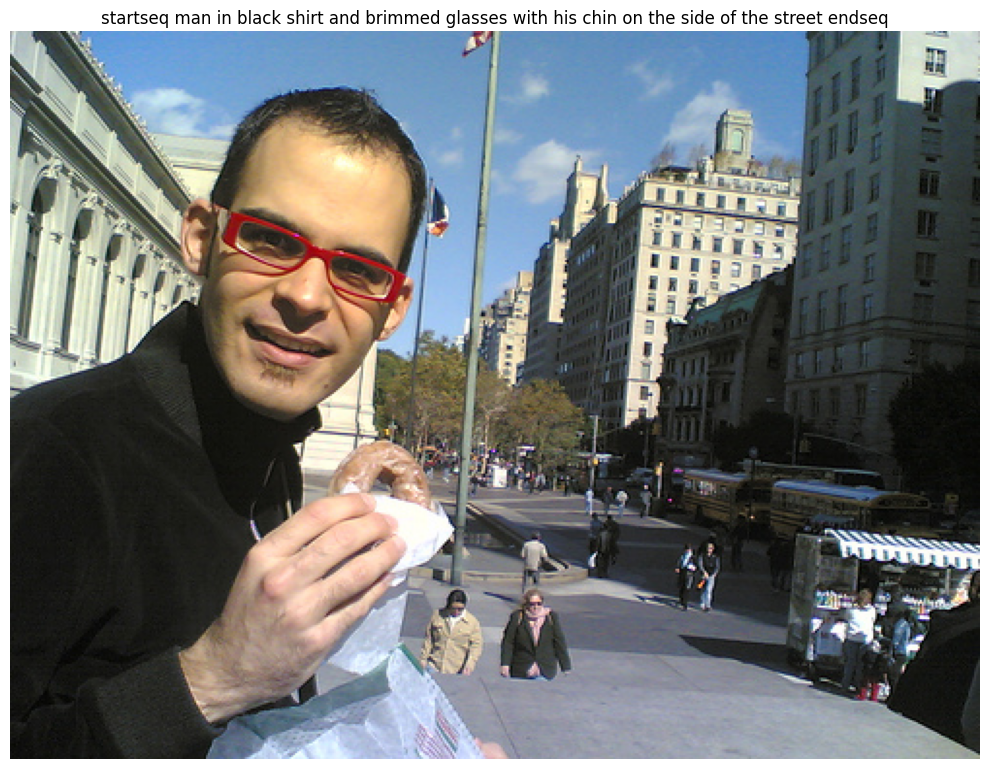

Sample caption image saved to image_caption\output\sample_caption.png


In [40]:
# Select a random image from the test set
random_key = random.choice(test)
if random_key in features:
    image_features = features[random_key]
    
    # Get the image file name (requires searching through original data)
    img_name_to_show = ""
    for annot in data['annotations']:
        if str(annot['image_id']) == random_key:
            img_name_to_show = f"{annot['image_id']:012d}.jpg"
            break

    if img_name_to_show:
        # Try to find the image in the dataset
        image_dir = 'dataset/train2017'
        if not os.path.exists(image_dir):
            image_dir = os.path.join('..', image_dir)
        
        img_path_to_show = os.path.join(image_dir, img_name_to_show)
        
        if os.path.exists(img_path_to_show):
            image = Image.open(img_path_to_show)
            
            caption = predict_caption(model, image_features, tokenizer, max_length)
            print("--------------------")
            print("Generated Caption:", caption)
            print("--------------------")

            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.title(caption, fontsize=12, wrap=True)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(working_dir, 'sample_caption.png'), dpi=150, bbox_inches='tight')
            plt.show()
            print(f"Sample caption image saved to {os.path.join(working_dir, 'sample_caption.png')}")
        else:
            print(f"Image file not found: {img_path_to_show}")
            print("Generated Caption:", predict_caption(model, image_features, tokenizer, max_length))
    else:
        print(f"Could not find a file name for image ID: {random_key}")
else:
    print(f"Features for random key {random_key} not found. Could not generate sample.")

In [ ]:
print("\nModel training and caption generation completed successfully!")
print(f"All outputs saved in '{working_dir}' directory.") 